# TP3 : Équations différentielles
## PHY-3500: Physique numérique (H2021) - 19 mars 2021


Mélissa Cinq-Mars (111 179 946)

Pierre-Olivier Janvier (111 187 987)

Maxence Larose (111 188 447)

In [1]:
#import packages
import astropy.constants as const
import numpy as np
import matplotlib.pyplot as plt

### Mécaniques céleste - comètes

#### Question a)

L'équation différentielle qui régit le mouvement du système comète-soleil est donné par:
$$ m \dfrac{d^2\textbf{r}}{dt^2} = - \left (\dfrac{GMm}{r^2} \right ) \dfrac{\textbf{r}}{r} $$

Puisqu'on considère que le mouvement est confiné dans un plan, les deux dimensions nécessaires pour décrire le mouvement sont données par les équations suivantes:
$$ \dfrac{d^2x}{dt^2} = -GM \dfrac{x}{r^3} $$


$$ \dfrac{d^2 y}{dt^2} = -GM \dfrac{y}{r^3} $$

Pour simplifier la démarche analytique, il est préférable de réécrire ces deux équations différentielles du deuxième ordre en quatre équations différentielles du premier ordre en utilisant un changement de variable suivant:

$$ \dfrac{dx}{dt} = v_x   \hspace{2cm}  \dfrac{dv_x}{dt} = -GM \dfrac{x}{r^3} $$

$$ \dfrac{dy}{dt} = v_y   \hspace{2cm}   \dfrac{dv_y}{dt} = -GM \dfrac{y}{r^3} $$

#### Question b)

In [2]:
class RK4_solver:

    
    def __init__(self, func, initial_conditions: list):
        super().__init__()
        
        self.func = func
        self.initial_conditions = initial_conditions

        
    def solve(self, a: float, b: float, N: int) -> float:
        h = (b-a)/N
        tpoints = np.arange(a, b, h)
        xpoints = []
        ypoints = []

        r = np.array(self.initial_conditions, float)
        
        for t in tpoints:
            xpoints.append(r[0])
            ypoints.append(r[1])
            
            r += self.get_delta(r, t, h)
        
        xpoints, ypoints = np.asarray(xpoints), np.asarray(ypoints)
        
        return xpoints, ypoints
    
    
    def get_delta(self, r: np.ndarray, t: float, h: float) -> float:
        k1 = h*f(r, t)
        k2 = h*f(r+0.5*k1, t+0.5*h)
        k3 = h*f(r+0.5*k2, t+0.5*h)
        k4 = h*f(r+k3, t+h)
        delta = (k1 + 2*k2 + 2*k3 + k4)/6 
        
        return delta
        

In [3]:
def f(r,t):
    G = const.G
    M = const.M_sun
    
    x, y, vx, vy = r
    R = np.sqrt(x**2 + y**2)

    f_x = vx
    f_y = vy
    f_vx = -G.value*M.value*x*R**-3
    f_vy = -G.value*M.value*y*R**-3
    
    return np.array([f_x, f_y, f_vx, f_vy], float)

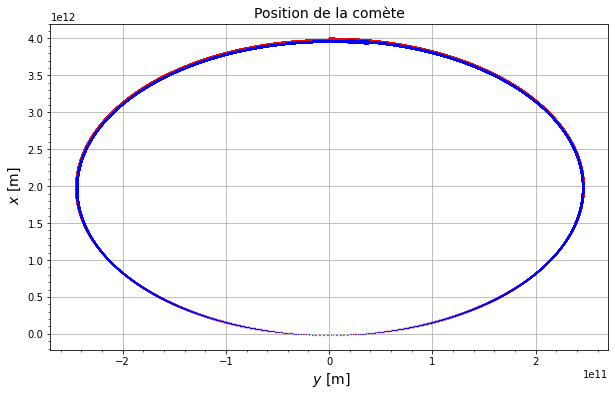

In [4]:
x0 = 4*10**12
y0 = 0
vx0 = 0
vy0 = 500 
initial_conditions = [x0, y0, vx0, vy0]
orbit = RK4_solver(func=f, initial_conditions=initial_conditions)

a = 0
b = 3.156e7*100
N = 100_000
xpoints, ypoints = orbit.solve(a=a, b=b, N=N)

fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(1, 1, 1)

line1, = ax.plot(np.split(ypoints, 2)[0], np.split(xpoints, 2)[0], marker='o', ls='None', color='r', markersize=0.3)
line2, = ax.plot(np.split(ypoints, 2)[1], np.split(xpoints, 2)[1], marker='o', ls='None', color='b', markersize=0.3)

ax.set_title("Position de la comète", fontsize=14)
ax.set_xlabel(" $y$ [m]", fontsize=14)
ax.set_xlim()
ax.set_ylabel(" $x$ [m]", fontsize=14)
ax.minorticks_on()

plt.grid()
plt.show()
plt.close(fig)

In [5]:
# # Exercice 8.10 


# # Created on Sat Aug 17 10:57:02 2013
# # @author: akels
# # """
# # from __future__ import division, print_function
# # from os import sys
# # sys.path.append('cpresources')
# # from pylab import *
# # from math import sqrt

# class rksolve:
	
# 	def __init__(self,f):
		
# 		self.f = f #self.array_decorator(f)
		
# 		self.initial_conditions = None
# 		self.solution = None
		
# 	def iterate(self,a,b,N=100000):
		
# 		#f = self.f
# 		r0 = np.array(self.initial_conditions,float)
		
# 		h = (b-a)/N
		
# 		tpoints = np.arange(a,b,h)
# 		solution = np.empty(tpoints.shape + r0.shape,float)
		
# 		#r_points[0] = r0
# 		r = r0
# 		for i,t in enumerate(tpoints):
# 		    solution[i]=r
# 		    r += self.estimate_delta(r,t,h)
		
# 		self.h = h
# 		self.solution = solution
# 		self.t = tpoints
		
# 	def estimate_delta(self,r,t,h):
		
# 		f = self.f
# 		k1 = h*f(r,t)
# 		k2 = h*f(r+0.5*k1,t+0.5*h)
# 		k3 = h*f(r+0.5*k2,t+0.5*h)
# 		k4 = h*f(r+k3,t+h)
# 		return (k1+2*k2+2*k3+k4)/6

# class rksolve_adaptive(rksolve):
	
# 	def iterate(self,a,b,delta=1):
		
		
# 		r0 = np.array(self.initial_conditions,float)
		
# 		h = (b-a)/10000
# 		solution = []
# 		time = []
# 		r = r0
# 		t = a
		
# 		solution.append(np.copy(r))
# 		time.append(t)
		
# 		ro = 1
# 		while t<b:	
# 			if ro<2:
# 				h = h*ro**(1/4)
# 			else:
# 				h*=2
# 			# estimating ro
# 			r1 = r + self.estimate_delta(r,t,h)
# 			r1 += self.estimate_delta(r1,t+h,h)			
# 			r2 = r + self.estimate_delta(r,t,2*h)
# 			difference = r1 - r2
# 			ro = 30*h*delta/np.sqrt(difference[0]**2 + difference[1]**2)
			
# 			if ro>1:
# 				t +=2*h
# 				r = r1
# 				solution.append(np.copy(r))
# 				time.append(t)
			
		
# 		self.h = h
# 		self.solution = np.array(solution)
# 		self.t = time


# G = 6.67e-11
# M = 1.9e30

# def f(r,t):
	
# 	x,y,vx,vy = r
	
# 	Dx = vx
# 	Dy = vy
	
# 	R = np.sqrt(x**2 + y**2)
	
# 	Dvx = -G*M*x/R**3
# 	Dvy = -G*M*y/R**3
	
# 	return np.array([Dx,Dy,Dvx,Dvy],float)
	
# #prob = rksolve(f)
# prob = rksolve_adaptive(f)


# R = 1.496e11
# T = 3.156e7 
# v = 2*np.pi*R/T
# print(v)
# prob.initial_conditions = [4e12,0,0,500]

# delta = 1e3/365/24/60/60
# # prob.iterate(0,T*100)
# prob.iterate(0, T*100, delta=delta)

# x = prob.solution[:,0]
# print(len(y))
# y = prob.solution[:,1]

# plt.plot(x,y,'.')
# plt.show()

#### Question c)

In [6]:
class RK4_adaptative_solver(RK4_solver):
    
    
    def solve(self, a: float, b: float, delta: float) -> float:
        h = (b-a)/10_000

        r = np.array(self.initial_conditions, float)
        
        tpoints = [a, ]
        xpoints = [r[0], ]
        ypoints = [r[1], ]
        
        t = a
        rho = 1
        while t < b:
            if rho < 2:
                h = h*(rho**(1/4))
            else:
                h = 2*h
            
            r1 = r + self.get_delta(r=r, t=t, h=h)
            r1 = r1 + self.get_delta(r=r1, t=t+h, h=h)
            
            r2 = r + self.get_delta(r=r, t=t, h=2*h)
            
            diff = r1 - r2
            rho = 30*h*delta/(np.sqrt(diff[0]**2 + diff[1]**2))
            
            if rho > 1:
                t = t + 2*h
                r = r1
                tpoints.append(t)
                xpoints.append(r[0])
                ypoints.append(r[1])
        
        xpoints, ypoints = np.asarray(xpoints), np.asarray(ypoints)
        
        return xpoints, ypoints


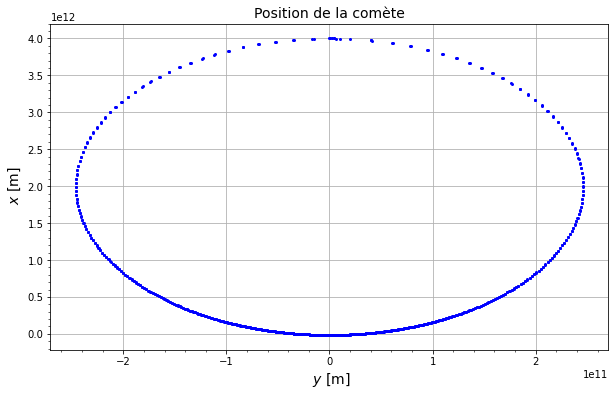

In [7]:
x0 = 4*10**12
y0 = 0
vx0 = 0
vy0 = 500 
initial_conditions = [x0, y0, vx0, vy0]
    
orbit = RK4_adaptative_solver(func=f, initial_conditions=initial_conditions)

a = 0
b = 3.156e7*100
delta = 1e3/(365*24*3600)
xpoints, ypoints = orbit.solve(a=a, b=b, delta=delta)

fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(1, 1, 1)

line1, = ax.plot(ypoints, xpoints, marker='o', ls='None', color='b', markersize=2)
# line1, = ax.plot(np.split(ypoints, 2)[0], np.split(xpoints, 2)[0], marker='o', ls='None', color='r', markersize=2)
# line2, = ax.plot(np.split(ypoints, 2)[1], np.split(xpoints, 2)[1], marker='o', ls='None', color='b', markersize=2)

ax.set_title("Position de la comète", fontsize=14)
ax.set_xlabel(" $y$ [m]", fontsize=14)
ax.set_xlim()
ax.set_ylabel(" $x$ [m]", fontsize=14)
ax.minorticks_on()

plt.grid()
plt.show()
plt.close(fig)

### Mécanique céleste - la Terre

#### Question d)

In [69]:
def f(r):
    G = const.G
    G = G.value* ( 8760 * 60 * 60) ** 2
    M = const.M_sun
    
    x, y, vx, vy = r
    R = np.sqrt(x**2 + y**2)

    f_x = vx
    f_y = vy
    f_vx = -G*M.value*x*R**-3
    f_vy = -G*M.value*y*R**-3
    
    return np.array([f_x, f_y, f_vx, f_vy], float)

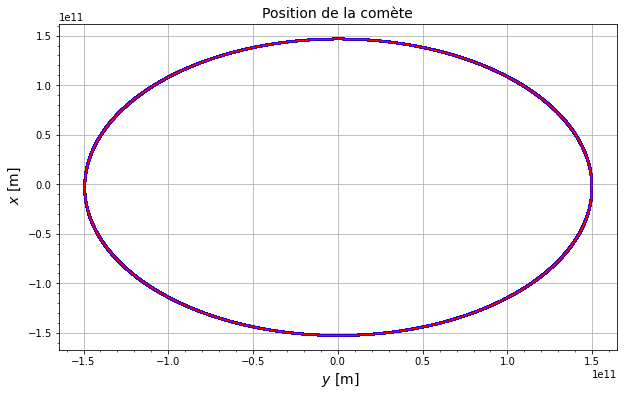

In [70]:
x0 = 1.4710*10**11
y0 = 0
vx0 = 0    
vy0 = (3.0287*10**4)*60*60*8760  #Vitesse en m/an

h = 1/8760   #Nombre d'heures dans une année
t0 = 0
t1 = 1
t2 = 2

""" Premier orbitre de la comète """
tpoints1 = np.arange(t0, t1, h)
xpoints1 = []
ypoints1 = []

r = np.array([x0, y0, vx0, vy0], float)
f_mid = 0.5*h*f(r)


vx_mid = r[2] + f_mid[2]
vy_mid = r[3] + f_mid[3]

for t in tpoints1:
    xpoints1.append(r[0])
    ypoints1.append(r[1])
    r[0] += h*vx_mid
    r[1] += h*vy_mid
    
    k = h*f(r)
    r[2] += vx_mid + 0.5*k[2]
    r[3] += vy_mid + 0.5*k[3]
    f_mid = 0.5*h*f(r)
    vx_mid += k[2]
    vy_mid += k[3]
    
tpoints2 = np.arange(t1, t2, h)
xpoints2 = []
ypoints2 = []
 
    
""" Deuxième orbitre de la comète """
for t in tpoints2:
    xpoints2.append(r[0])
    ypoints2.append(r[1])
    r[0] += h*vx_mid
    r[1] += h*vy_mid
    
    k = h*f(r)
    r[2] += vx_mid + 0.5*k[2]
    r[3] += vy_mid + 0.5*k[3]
    f_mid = 0.5*h*f(r)
    vx_mid += k[2]
    vy_mid += k[3]
    
    
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(1, 1, 1)

orbit1, = ax.plot(ypoints1, xpoints1, marker='o', ls='None', color='b', markersize=2)
orbit2, = ax.plot(ypoints2, xpoints2, marker='o', ls='None', color='r', markersize=0.2)

ax.set_title("Position de la comète", fontsize=14)
ax.set_xlabel(" $y$ [m]", fontsize=14)
ax.set_xlim()
ax.set_ylabel(" $x$ [m]", fontsize=14)
ax.minorticks_on()

plt.grid()
plt.show()
plt.close(fig)


#### Question e)

In [74]:
G = const.G   #[m^3 kg^-1 s^-2]
M = const.M_sun
m = const.M_earth


t0 = 0
tf = 30 #années
h = 1/8760   #Nombre d'heures dans une année

x0 = 1.4710*10**11
y0 = 0
vx0 = 0    
vy0 = (3.0287*10**4)*60*60*8760  #Vitesse en m/an
r = np.array([x0, y0, vx0, vy0], float)

f_mid = 0.5*h*f(r)
vx_mid = r[2] + f_mid[2]
vy_mid = r[3] + f_mid[3]

tpoints = np.arange(t0, tf, h)
xpoints = []
ypoints = []
P = [] #Énergie potentielle 
K = [] #Énergie cinétique 



for t in tpoints:
    xpoints.append(r[0])
    ypoints.append(r[2])
    R = np.sqrt(r[0]**2 + r[1]**2)
    #v = (r[2]**2 + r[3]**2)/((60*60*8760)**2)
    P.append(-G.value * M.value * m.value / R)       #Le corrigé ne met pas le moins dans l'énergie potentielle?
    K.append(0.5 * m.value * (r[2]**2 + r[3]**2)/((60*60*8760)**2))
    r[0] += h * vx_mid
    r[1] += h * vy_mid
    k = h * f(r)
    r[2] = vx_mid + 0.5 * k[2]
    r[3] = vy_mid + 0.5 * k[3]
    f_mid = 0.5 * h * f(r)
    vx_mid += k[2]
    vy_mid += k[3]
             
total_energy = np.array(K, float) + np.array(P, float)  #Somme des énergies potentielle et cinétique


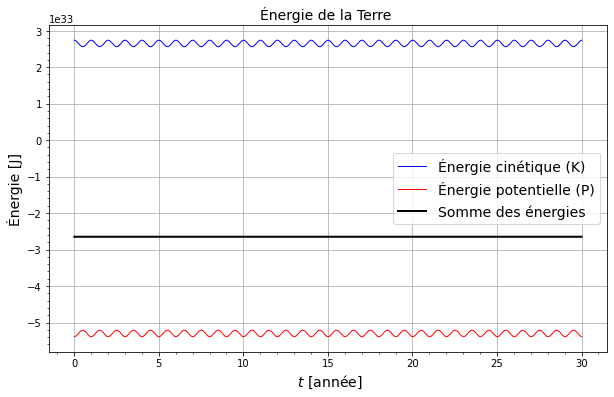

In [75]:
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(1, 1, 1)

kinetic, = ax.plot(tpoints, K, ls='-', color='b', linewidth='1', label="Énergie cinétique (K)")
potential, = ax.plot(tpoints, P, ls='-', color='r', linewidth='1', label="Énergie potentielle (P)")
energy_sum, = ax.plot(tpoints, total_energy, ls='-', color='k', linewidth='2', label="Somme des énergies" )

ax.set_title("Énergie de la Terre ", fontsize=14)
ax.set_xlabel(" $t$ [année]", fontsize=14)
ax.set_xlim()
ax.set_ylabel("Énergie [J]", fontsize=14)
ax.minorticks_on()

plt.legend(handles=[kinetic, potential, energy_sum], fontsize=14, loc='best')
plt.grid()
plt.show()
plt.close(fig)


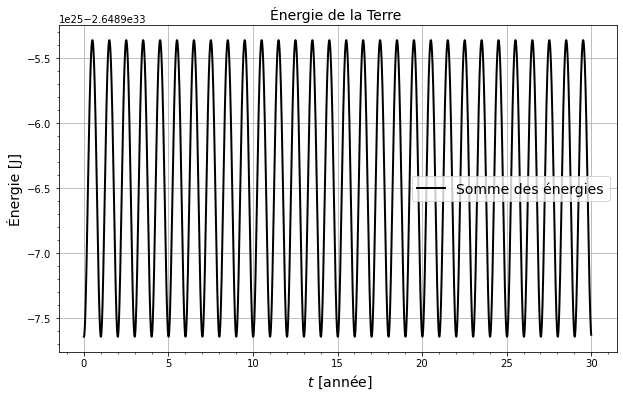

In [76]:
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(1, 1, 1)

energy_sum, = ax.plot(tpoints, total_energy, ls='-', color='k', linewidth='2', label="Somme des énergies" )

ax.set_title("Énergie de la Terre ", fontsize=14)
ax.set_xlabel(" $t$ [année]", fontsize=14)
ax.set_xlim()
ax.set_ylabel("Énergie [J]", fontsize=14)
ax.minorticks_on()

plt.legend(handles=[energy_sum], fontsize=14, loc='best')
plt.grid()
plt.show()
plt.close(fig)


Observations:



#### Question f)

In [77]:
class RK2_solver(RK4_solver):
 

    def get_energies(self, a: float, b: float, N: int) -> float:
        h = (b-a)/N
        tpoints = np.arange(a, b, h)
        P = [] #Énergie potentielle 
        K = [] #Énergie cinétique
        
        r = np.array(self.initial_conditions, float)
        
        for t in tpoints:
            R = np.sqrt(r[0]**2 + r[1]**2)
            P.append(-G.value * M.value * m.value / R)
            K.append(0.5 * m.value * (r[2]**2 + r[3]**2))
            
            r += self.get_delta(r, t, h)
        
        total_energy = np.array(K, float) + np.array(P, float)
        
        return tpoints, P, K, total_energy
        
    
    def get_delta(self, r: np.ndarray, t: float, h: float) -> float:
        k1 = h*f(r, t)
        k2 = h*f(r+0.5*k1, t+0.5*h)
        delta = k2
        
        return delta


In [78]:
def f(r,t):
    G = const.G
    M = const.M_sun
    
    x, y, vx, vy = r
    R = np.sqrt(x**2 + y**2)

    f_x = vx
    f_y = vy
    f_vx = -G.value*M.value*x*R**-3
    f_vy = -G.value*M.value*y*R**-3
    
    return np.array([f_x, f_y, f_vx, f_vy], float)

In [79]:
t0 = 0
tf = 2 # années

x0 = 1.4710*10**11
y0 = 0
vx0 = 0    
vy0 = 3.0287*10**4  # Vitesse en m/an

initial_conditions = [x0, y0, vx0, vy0]
orbit = RK2_solver(func=f, initial_conditions=initial_conditions)


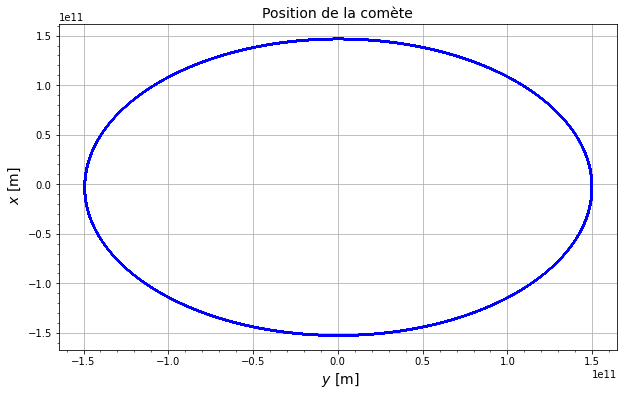

In [80]:
xpoints, ypoints = orbit.solve(a=a, b=b, N=N)

fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(1, 1, 1)

orbit1, = ax.plot(ypoints, xpoints, marker='o', ls='None', color='b', markersize=0.3)

ax.set_title("Position de la comète", fontsize=14)
ax.set_xlabel(" $y$ [m]", fontsize=14)
ax.set_xlim()
ax.set_ylabel(" $x$ [m]", fontsize=14)
ax.minorticks_on()

plt.grid()
plt.show()
plt.close(fig)


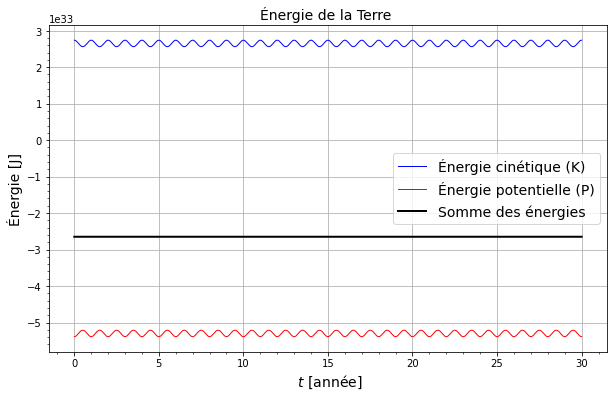

In [81]:
t0 = 0
tf = 30 # années

a = 0
b = 3.156e7*tf
N = 100_000

tpoints, P, K, total_energy = orbit.get_energies(a=a, b=b, N=N)
tpoints = tpoints/3.156e7

fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(1, 1, 1)

kinetic, = ax.plot(tpoints, K, ls='-', color='b', linewidth='1', label="Énergie cinétique (K)")
potential, = ax.plot(tpoints, P, ls='-', color='r', linewidth='1', label="Énergie potentielle (P)")
energy_sum, = ax.plot(tpoints, total_energy, ls='-', color='k', linewidth='2', label="Somme des énergies" )

ax.set_title("Énergie de la Terre ", fontsize=14)
ax.set_xlabel(" $t$ [année]", fontsize=14)
ax.set_xlim()
ax.set_ylabel("Énergie [J]", fontsize=14)
ax.minorticks_on()

plt.legend(handles=[kinetic, potential, energy_sum], fontsize=14, loc='best')
plt.grid()
plt.show()
plt.close(fig)


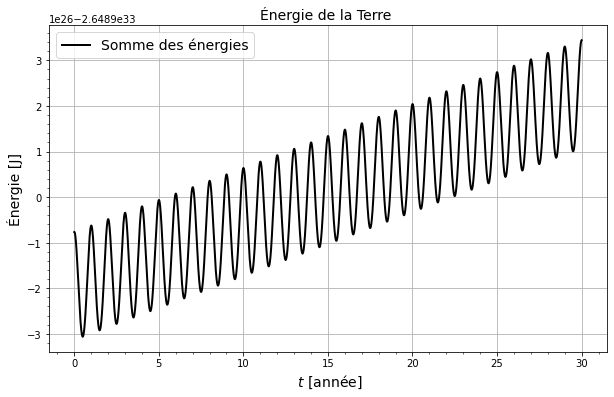

In [82]:
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(1, 1, 1)

energy_sum, = ax.plot(tpoints, total_energy, ls='-', color='k', linewidth='2', label="Somme des énergies" )

ax.set_title("Énergie de la Terre ", fontsize=14)
ax.set_xlabel(" $t$ [année]", fontsize=14)
ax.set_xlim()
ax.set_ylabel("Énergie [J]", fontsize=14)
ax.minorticks_on()

plt.legend(handles=[energy_sum], fontsize=14, loc='best')
plt.grid()
plt.show()
plt.close(fig)


Observation : https://femto-physique.fr/omp/methode-de-verlet.php#:~:text=Un%20des%20algorithmes%20symplectiques%20les,))%2Bh33!


#### Question g)

### Mécanique céleste - Mars

#### Question h)